In [31]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
maindir = "D:/Blood/data" # Directory with files
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [33]:
# Define target columns
target_columns = ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']

# Separate features and targets
X_train = train.drop(columns=target_columns)
X_train.drop(columns='Reading_ID', axis=1, inplace=True)
y_train = train[target_columns]

X_test = test

In [34]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in target_columns:
    encoder = LabelEncoder()
    y_train[col] = encoder.fit_transform(y_train[col])
    encoders[col] = encoder

In [35]:
from sklearn.metrics import mutual_info_score

# Calculate MI for each pair of targets
for i in range(len(target_columns)):
    for j in range(i + 1, len(target_columns)):
        mi = mutual_info_score(y_train[target_columns[i]], y_train[target_columns[j]])
        print(f"Mutual Information between {target_columns[i]} and {target_columns[j]}: {mi:.2f}")


Mutual Information between hdl_cholesterol_human and hemoglobin(hgb)_human: 0.01
Mutual Information between hdl_cholesterol_human and cholesterol_ldl_human: 0.01
Mutual Information between hemoglobin(hgb)_human and cholesterol_ldl_human: 0.01


In [36]:
# Load mRMR selected features from JSON
with open("selected_features.json", "r") as file:
    selected_features = json.load(file)

In [37]:
# Apply selected features to train and test data
X_train_target1 = X_train[selected_features["Target1"]]
X_train_target2 = X_train[selected_features["Target2"]]
X_train_target3 = X_train[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

In [38]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

# Redo Stratified K-Fold for each target
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store splits for each target
splits = {}

# Process each target
for target, X_target in target_to_dataset.items():
    
    # Get the corresponding labels
    y_target = y_train[target]
    
    # Compute Stratified K-Fold splits
    splits[target] = list(skf.split(X_target, y_target))

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    # Access target-specific dataset and labels
    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        # Train the model
        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        # Validate the model
        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        # Store fold results
        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")



=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.6499
  Fold 2: Accuracy = 0.6663
  Fold 3: Accuracy = 0.6545
  Fold 4: Accuracy = 0.6495
  Fold 5: Accuracy = 0.6454

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 0.9041
  Fold 2: Accuracy = 0.9053
  Fold 3: Accuracy = 0.9026
  Fold 4: Accuracy = 0.9026
  Fold 5: Accuracy = 0.9041

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.6762
  Fold 2: Accuracy = 0.6629
  Fold 3: Accuracy = 0.6659
  Fold 4: Accuracy = 0.6705
  Fold 5: Accuracy = 0.6739

hdl_cholesterol_human Average Accuracy: 0.6531

hemoglobin(hgb)_human Average Accuracy: 0.9037

cholesterol_ldl_human Average Accuracy: 0.6699


In [63]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Objective function
def objective(params):
    # Unpack hyperparameters
    n_estimators = int(params["n_estimators"])
    max_depth = int(params["max_depth"])
    min_samples_split = int(params["min_samples_split"])
    min_samples_leaf = int(params["min_samples_leaf"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    accuracy = cross_val_score(model, X_train, y_train.iloc[:,0], cv=5, scoring="accuracy").mean()

    # Return negative accuracy (because Hyperopt minimizes)
    return {"loss": -accuracy, "status": STATUS_OK}

In [64]:
# Define the hyperparameter space
search_space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),  
    "max_depth": hp.quniform("max_depth", 5, 50, 5),          
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),  
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1)      
}

In [65]:
trials = Trials()

best_params = fmin(
    fn=objective,                
    space=search_space,          
    algo=tpe.suggest,            # Tree of Parzen Estimators (TPE) algorithm
    max_evals=10,                
    trials=trials,              
    rstate=np.random.default_rng(42)  
)

print("Best Hyperparameters:", best_params)

100%|██████████████████████████████████████████████| 10/10 [22:56<00:00, 137.60s/trial, best loss: -0.5928462709284628]
Best Hyperparameters: {'max_depth': 30.0, 'min_samples_leaf': 1.0, 'min_samples_split': 16.0, 'n_estimators': 230.0}


In [66]:
# Convert best_params to integers (if necessary)
best_params = {
    "n_estimators": int(best_params["n_estimators"]),
    "max_depth": int(best_params["max_depth"]),
    "min_samples_split": int(best_params["min_samples_split"]),
    "min_samples_leaf": int(best_params["min_samples_leaf"]),
}

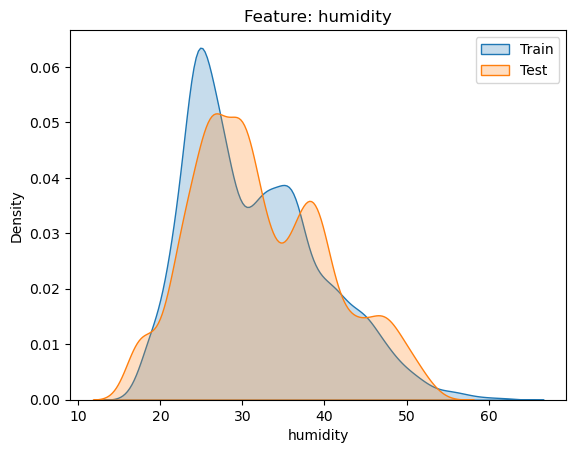

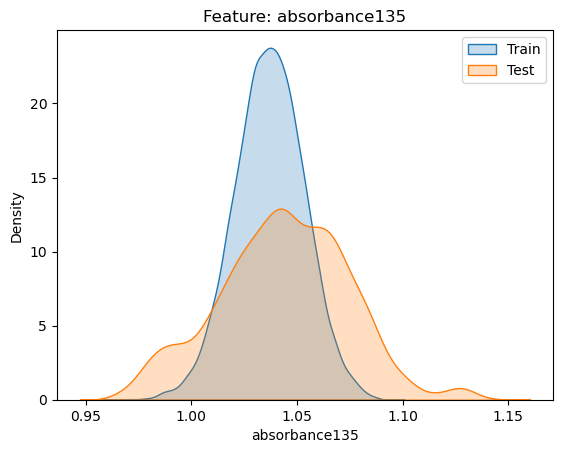

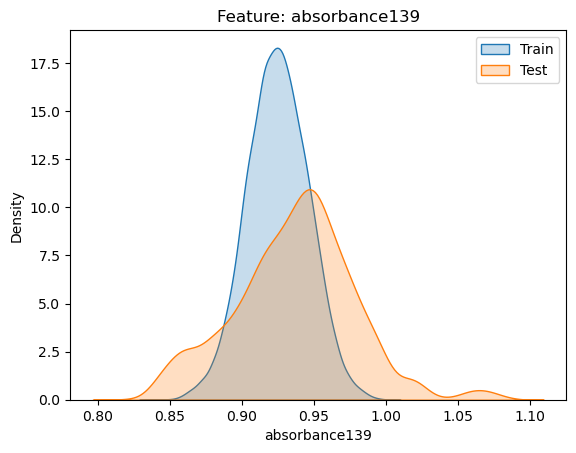

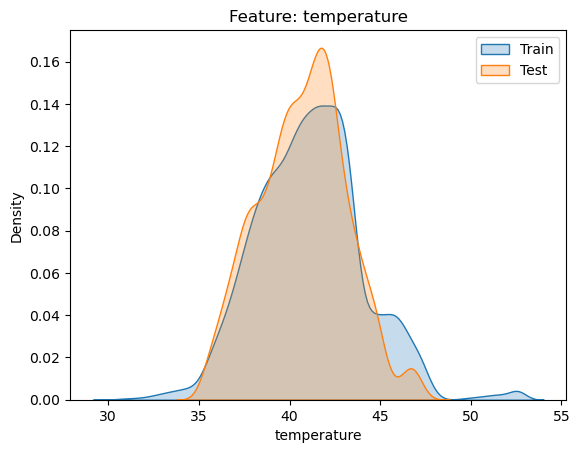

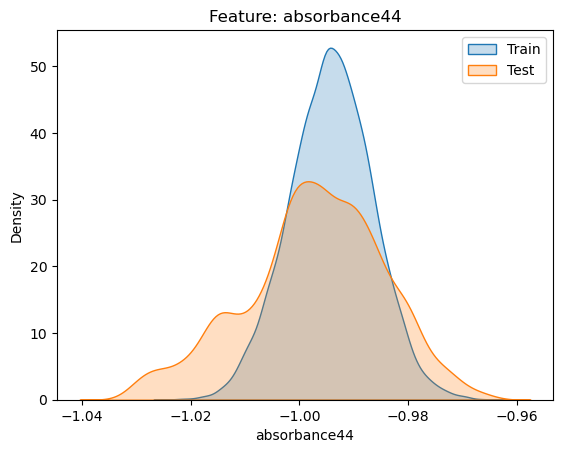

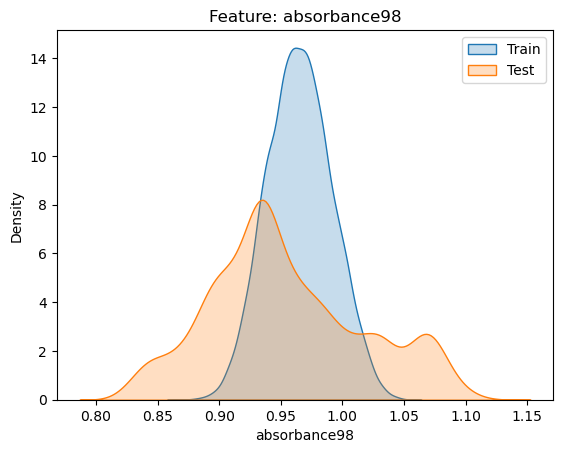

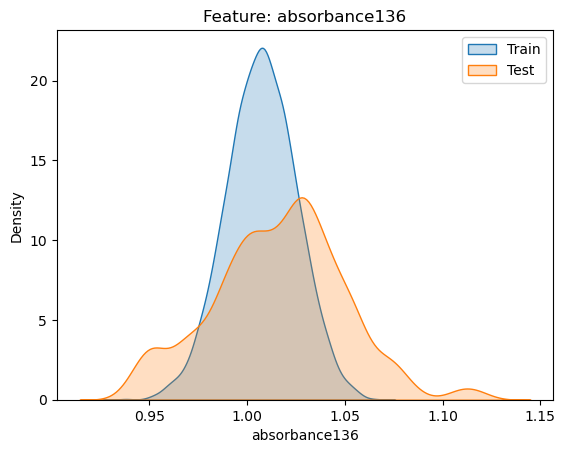

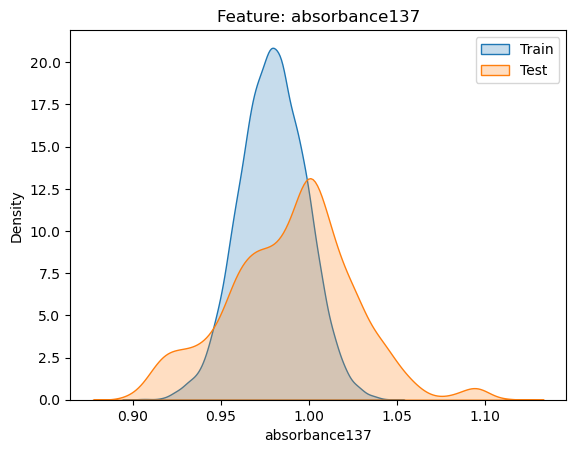

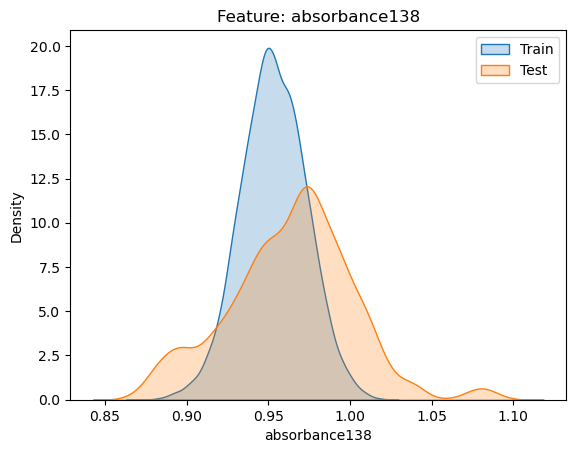

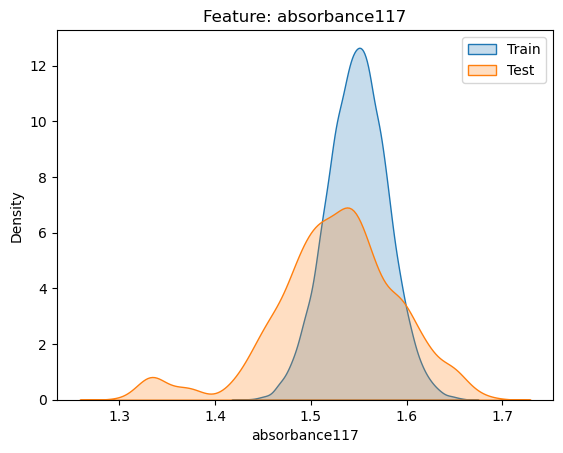

In [39]:
#Distribution 
for column in X_train_target1.columns:
    sns.kdeplot(X_train_target1[column], label='Train', shade=True)
    sns.kdeplot(X_test[column], label='Test', shade=True)
    plt.title(f"Feature: {column}")
    plt.legend()
    plt.show()


In [44]:
from scipy.stats import ks_2samp
for col in X_train_target1.columns.tolist():
    stat, p_value = ks_2samp(X_train_target1[col], X_test[col])
    print(f"KS Statistic for {col}: {stat}, P-value: {p_value}")


KS Statistic for humidity: 0.07087481597924, P-value: 5.967959453908019e-13
KS Statistic for absorbance135: 0.24190558175512133, P-value: 5.832085951670451e-148
KS Statistic for absorbance139: 0.26950370536716817, P-value: 3.8177630897310995e-184
KS Statistic for temperature: 0.08047383786211537, P-value: 1.4166463815453258e-16
KS Statistic for absorbance44: 0.17124909549117948, P-value: 7.018452996546863e-74
KS Statistic for absorbance98: 0.30973001971205427, P-value: 1.9987121791666307e-244
KS Statistic for absorbance136: 0.2589340519499962, P-value: 8.520074147497878e-170
KS Statistic for absorbance137: 0.2731092646655189, P-value: 3.5212002098586013e-189
KS Statistic for absorbance138: 0.26444843675923846, P-value: 3.3184173282018935e-177
KS Statistic for absorbance117: 0.2659430596102503, P-value: 3.0475689083455394e-179



Visualizing dataset shift for target: hdl_cholesterol_human


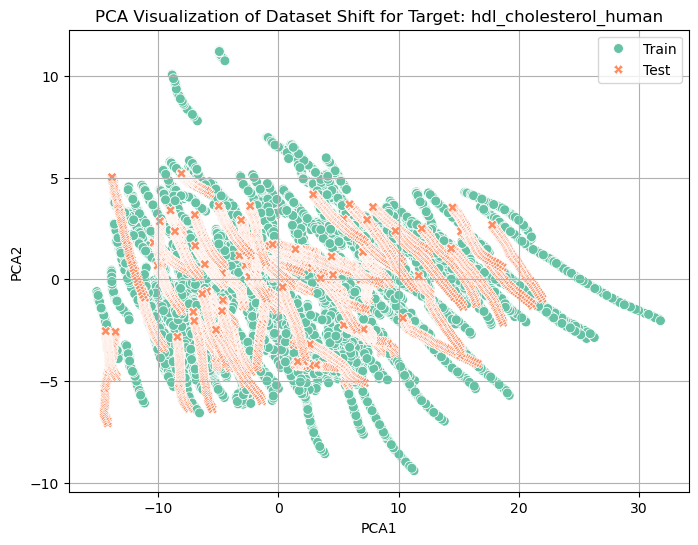


Visualizing dataset shift for target: hemoglobin(hgb)_human


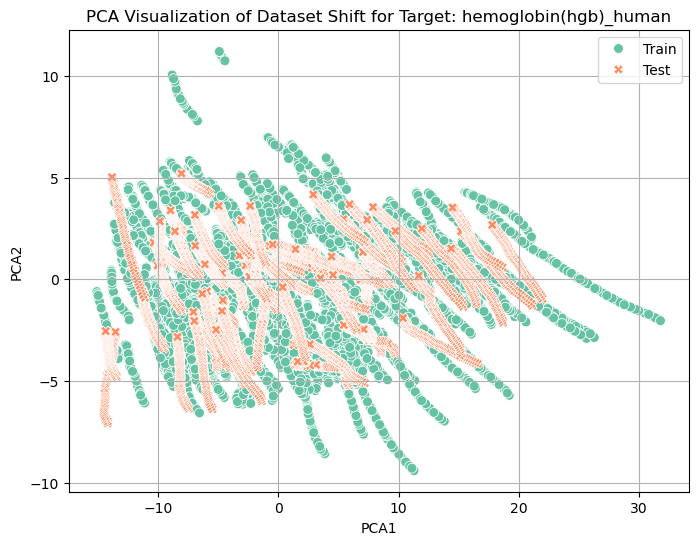


Visualizing dataset shift for target: cholesterol_ldl_human


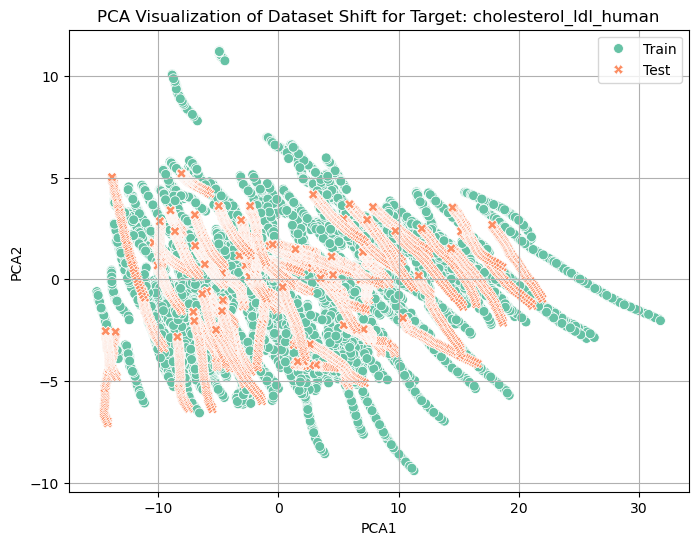

In [48]:
from sklearn.decomposition import PCA

# Function to visualize dataset shifts
def visualize_dataset_shift(X_train, X_test, target_name):
    """
    Visualizes the dataset shift between train and test sets for a given target using PCA.

    Parameters:
    - X_train: Train feature matrix (Pandas DataFrame).
    - X_test: Test feature matrix (Pandas DataFrame).
    - target_name: Name of the target being visualized (string).
    """
    print(f"\nVisualizing dataset shift for target: {target_name}")

    X_train['Dataset'] = 'Train'
    X_test['Dataset'] = 'Test'

    combined_data = pd.concat([X_train, X_test], axis=0)

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(combined_data.drop('Dataset', axis=1))

    pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
    pca_df['Dataset'] = combined_data['Dataset'].values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Dataset', style='Dataset', palette='Set2', s=50)
    plt.title(f"PCA Visualization of Dataset Shift for Target: {target_name}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.grid()
    plt.show()


visualize_dataset_shift(X_train_target1, X_test_target1, "hdl_cholesterol_human")
visualize_dataset_shift(X_train_target2, X_test_target2, "hemoglobin(hgb)_human")
visualize_dataset_shift(X_train_target3, X_test_target3, "cholesterol_ldl_human")
